<a href="https://colab.research.google.com/github/deepsharma26/SIRT1_ML_NPASS/blob/main/Part7(b)_XAI_for_XGB_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Here, we will use further the explainble-AI (XAI) approch using SHAP module for the selected models

In [ ]:
pip install shap

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Loading the saved XGB + ROS model

import pickle

with open("XGB_ROS_model.pkl", "rb") as f: #change the model name accordingly
    model = pickle.load(f)

# Loading Test set

import pandas as pd

# Load complete test set #change the test set name accordingly
test_df = pd.read_csv("XGB_ROS_Testset.csv")

# Separate X (features) and y (labels)
X_test = test_df.drop("BioactivityClass", axis=1)
y_test = test_df["BioactivityClass"]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (817, 20)
y_test shape: (817,)


#If your saved model is tree-based (RandomForest, XGBoost, LightGBM, CatBoost
use TreeExplainer (fast, accurate)

#If it’s not tree-based (SVM, Logistic Regression, MLP, QDA, etc.):
use KernelExplainer (model-agnostic but slower)

Explaining samples: (300, 20)


  0%|          | 0/300 [00:00<?, ?it/s]

raw shap_values type: <class 'numpy.ndarray'>
Selected shap_values for class 1 (positive) from a 3D numpy array.
shap_values_to_use.shape: (300, 20)
X_explain.shape: (300, 20)
Saved SHAP CSV -> shap_values_class1.csv
Saved SHAP NPZ -> shap_values_class1.npz
Saved predicted labels for the explained samples.
Saved class-1 probabilities -> explained_sample_prob_class1.csv
Saved feature importance (mean abs shap) -> shap_feature_importance_mean_abs.csv


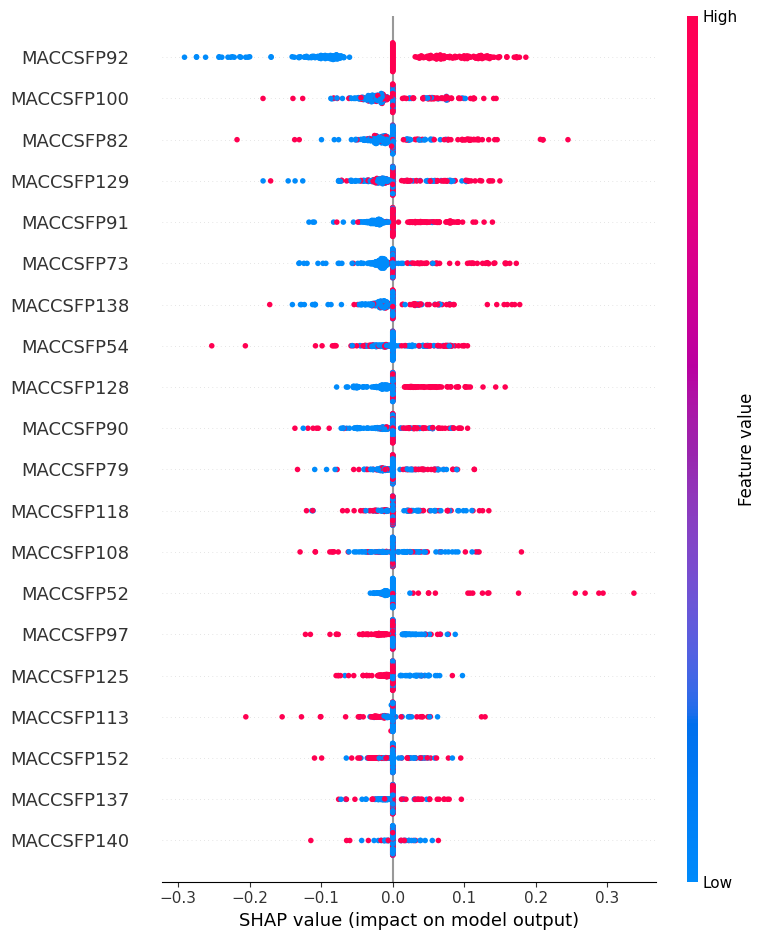

Saved beeswarm -> SHAP_summary_beeswarm.png
Saved long-format SHAP (sample × feature × value) -> shap_values_long_format.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Triggered download for key files (Colab).

--- Diagnostics ---
SHAP dataframe head:
   MACCSFP52  MACCSFP54  MACCSFP73  MACCSFP79  MACCSFP82  MACCSFP90  \
0  -0.013122   0.000000   -0.01561   0.000000  -0.011555   0.000000   
1   0.000000  -0.021885    0.00000  -0.017646  -0.034608   0.000000   
2   0.000000   0.104442    0.00000   0.059207   0.077396   0.055809   
3   0.035790  -0.010827   -0.00860  -0.014053   0.000000   0.000000   
4   0.000000   0.048698    0.00000   0.042495   0.112931   0.000000   

   MACCSFP91  MACCSFP92  MACCSFP97  MACCSFP100  MACCSFP108  MACCSFP113  \
0  -0.016703  -0.073518   0.000000   -0.034145    0.000000   -0.012344   
1   0.000000   0.000000  -0.019825   -0.045513    0.000000    0.000000   
2   0.037288   0.127801   0.000000    0.094413    0.000000    0.000000   
3  -0.033171  -0.131765  -0.017601   -0.021287    0.000000    0.000000   
4   0.000000   0.125259   0.031860    0.000000    0.043151    0.000000   

   MACCSFP118  MACCSFP125  MACCSFP128  MACCS

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ----- USER: adjust these if your variables have different names -----
model_var = 'XGB_ROS_model'          # name of your trained model variable in the notebook (usually `model`)
X_test_var = 'XGB_ROS_Testset'        # name of your test DataFrame variable (usually `X_test`)
# --------------------------------------------------------------------

# 1) Clean X_test (drop NaNs) and pick subset to explain
X_test_cleaned = X_test.dropna()
max_samples = min(300, len(X_test_cleaned))
X_explain = X_test_cleaned.iloc[:max_samples].copy()
print("Explaining samples:", X_explain.shape)

# FIX: Use KernelExplainer for non-tree models like QuadraticDiscriminantAnalysis
# TreeExplainer is only for tree-based models (XGBoost, RandomForest, etc.)
# KernelExplainer needs a prediction function (model.predict_proba for classification)
# and a background dataset.

# Create a background dataset for KernelExplainer (e.g., a sample from X_test_cleaned)
# Using a small sample for background to speed up KernelExplainer
X_background = shap.sample(X_test_cleaned, 100) # Use 100 samples from the cleaned test set as background

# 2) Build KernelExplainer
# Use model.predict_proba for classification models that output probabilities
explainer = shap.KernelExplainer(model.predict_proba, X_background)

# 3) Compute SHAP values (this returns a numpy array or a list for multiclass)
# Note: KernelExplainer can be slow for large datasets. X_explain is already a subset.
shap_values = explainer.shap_values(X_explain)
print("raw shap_values type:", type(shap_values))

# 4) Normalize shap_values into a 2D array for class-1 if needed
if isinstance(shap_values, list) and len(shap_values) >= 2:
    # typical XGBoost/sklearn multiclass output: [class0_shap, class1_shap, ...]
    # For binary classification most users want the positive class (class 1)
    shap_values_to_use = np.asarray(shap_values[1])
    print("Using shap_values for class 1 (positive).")
else:
    # If shap_values is a single array, it's likely for a binary classification where
    # SHAP calculates values for one class directly, or a 3D array.
    shap_values_to_use = np.asarray(shap_values)
    # If it's a 3D array (samples, features, classes), select the SHAP values for class 1
    if shap_values_to_use.ndim == 3 and shap_values_to_use.shape[2] >= 2:
        shap_values_to_use = shap_values_to_use[:, :, 1] # Select SHAP values for class 1
        print("Selected shap_values for class 1 (positive) from a 3D numpy array.")
    elif shap_values_to_use.ndim == 3 and shap_values_to_use.shape[2] == 1:
        shap_values_to_use = shap_values_to_use.squeeze(axis=2) # Remove the singleton dimension
        print("Squeezed 3D shap_values with single output dimension to 2D.")

print("shap_values_to_use.shape:", shap_values_to_use.shape)
print("X_explain.shape:", X_explain.shape)
if shap_values_to_use.shape[0] != X_explain.shape[0] or shap_values_to_use.shape[1] != X_explain.shape[1]:
    raise RuntimeError("Shape mismatch between SHAP values and X_explain. "
                       "Ensure your model input features match X_explain columns.")

# 5) Build DataFrame of SHAP values (samples x features) and save
shap_df = pd.DataFrame(shap_values_to_use, index=X_explain.index, columns=X_explain.columns)
csv_name = "shap_values_class1.csv"
npz_name = "shap_values_class1.npz"
shap_df.to_csv(csv_name, index=True)
np.savez_compressed(npz_name, shap=shap_values_to_use, index=np.array(X_explain.index), columns=np.array(X_explain.columns))
print(f"Saved SHAP CSV -> {csv_name}")
print(f"Saved SHAP NPZ -> {npz_name}")

# 6) Add model predictions/probabilities for the explained samples (if available)
preds = None
probs = None
try:
    preds = model.predict(X_explain)
    print("Saved predicted labels for the explained samples.")
except Exception:
    print("model.predict() not available or failed (this is OK).")

try:
    probs = model.predict_proba(X_explain)
    # store class-1 probability column if binary
    if probs is not None and probs.shape[1] >= 2:
        prob_series = pd.Series(probs[:,1], index=X_explain.index, name="prob_class1")
        prob_series.to_csv("explained_sample_prob_class1.csv")
        print("Saved class-1 probabilities -> explained_sample_prob_class1.csv")
except Exception:
    print("model.predict_proba() not available or failed (this is OK).")

# 7) Compute per-feature importance (mean absolute SHAP) and save
feat_importance = pd.DataFrame({
    "feature": X_explain.columns,
    "mean_abs_shap": np.abs(shap_df).mean(axis=0).values,
    "mean_shap": shap_df.mean(axis=0).values
}).sort_values("mean_abs_shap", ascending=False)
feat_importance.to_csv("shap_feature_importance_mean_abs.csv", index=False)
print("Saved feature importance (mean abs shap) -> shap_feature_importance_mean_abs.csv")

# 8) Recreate beeswarm summary plot (same as your plot) and save
plt.figure(figsize=(8,10))
shap.summary_plot(shap_values_to_use, X_explain, feature_names=X_explain.columns, show=False)
plt.tight_layout()
plt.savefig("SHAP_summary_beeswarm.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved beeswarm -> SHAP_summary_beeswarm.png")

# 9) Extra: a long-format table (sample, feature, shap_value) if you want per-point analysis
long_df = shap_df.reset_index().melt(id_vars=X_explain.index.name or "index", var_name="feature", value_name="shap_value")
# If index name was None, pandas uses "index" — it's fine. Save long form too (smaller sets OK).
long_csv = "shap_values_long_format.csv"
long_df.to_csv(long_csv, index=False)
print(f"Saved long-format SHAP (sample × feature × value) -> {long_csv}")

# 10) Attempt to trigger download in Colab (best-effort; harmless if not in Colab)
try:
    from google.colab import files
    files.download(csv_name)
    files.download(npz_name)
    files.download("shap_feature_importance_mean_abs.csv")
    files.download("SHAP_summary_beeswarm.png")
    print("Triggered download for key files (Colab).")
except Exception:
    print("Not running in Colab or browser download failed — files are saved in the notebook working directory. "
          "Use the Files pane or !zip + download if needed.")

# 11) Quick diagnostics printout to confirm values (first rows)
print("\n--- Diagnostics ---")
print("SHAP dataframe head:")
print(shap_df.head())
print("\nTop features by mean(|SHAP|):")
print(feat_importance.head(20))

In [ ]:
!zip -r XAI_XGB_ROS_SHAP * .csv * .png

	zip warning: name not matched: .csv
	zip warning: name not matched: .png
  adding: explained_sample_prob_class1.csv (deflated 57%)
  adding: sample_data/ (stored 0%)
  adding: sample_data/README.md (deflated 39%)
  adding: sample_data/anscombe.json (deflated 83%)
  adding: sample_data/california_housing_test.csv (deflated 76%)
  adding: sample_data/mnist_test.csv (deflated 88%)
  adding: sample_data/mnist_train_small.csv (deflated 88%)
  adding: sample_data/california_housing_train.csv (deflated 79%)
  adding: shap_feature_importance_mean_abs.csv (deflated 53%)
  adding: SHAP_summary_beeswarm.png (deflated 9%)
  adding: shap_values_class1.csv (deflated 59%)
  adding: shap_values_class1.npz (deflated 0%)
  adding: shap_values_long_format.csv (deflated 71%)
  adding: XGB_ROS_model.pkl (deflated 10%)
  adding: XGB_ROS_Testset.csv (deflated 94%)
